In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

2024-07-19 04:13:23.310931: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 04:13:23.365174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 04:13:24.138381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Make original data

In [2]:
series = np.sin((0.1 * np.arange(400))**2)

This is a time series of the form:
$$
x(t) = sin(\omega t^2)
$$

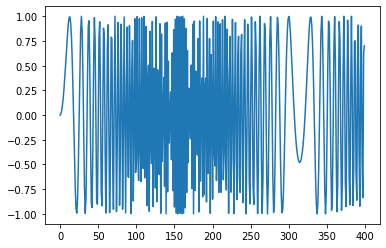

In [3]:
plt.plot(series)
plt.show()

## Build the dataset

In [4]:
T = 10
D = 1
X = []
Y = []

for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T)    # N x T
Y = np.array(Y)
N = len(X)

In [5]:
X.shape, Y.shape

((390, 10), (390,))

## Try autoregressive linear model

In [6]:
i = Input(shape=(T,))
x = Dense(1)(i)

model = Model(i, x)

2024-07-19 04:13:26.101004: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

In [8]:
# train the RNN
r = model.fit(X[:-N//2], Y[:-N//2],
             epochs=80,
             validation_data=(X[-N//2:], Y[-N//2:]))

Epoch 1/80
7/7 [==============================] - 0s 25ms/step - loss: 2.0167 - val_loss: 1.1895
Epoch 2/80
7/7 [==============================] - 0s 6ms/step - loss: 1.6517 - val_loss: 1.0895
Epoch 3/80
7/7 [==============================] - 0s 7ms/step - loss: 1.4217 - val_loss: 0.9810
Epoch 4/80
7/7 [==============================] - 0s 6ms/step - loss: 1.2179 - val_loss: 0.8866
Epoch 5/80
7/7 [==============================] - 0s 6ms/step - loss: 1.0690 - val_loss: 0.8073
Epoch 6/80
7/7 [==============================] - 0s 6ms/step - loss: 0.9411 - val_loss: 0.7393
Epoch 7/80
7/7 [==============================] - 0s 6ms/step - loss: 0.8377 - val_loss: 0.6904
Epoch 8/80
7/7 [==============================] - 0s 7ms/step - loss: 0.7600 - val_loss: 0.6463
Epoch 9/80
7/7 [==============================] - 0s 7ms/step - loss: 0.7005 - val_loss: 0.6135
Epoch 10/80
7/7 [==============================] - 0s 7ms/step - loss: 0.6537 - val_loss: 0.5885
Epoch 11/80
7/7 [=====================

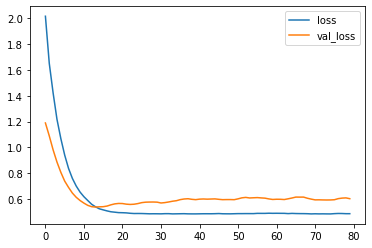

In [9]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [10]:
# One step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

13/13 [==============================] - 0s 858us/step
(390, 1)


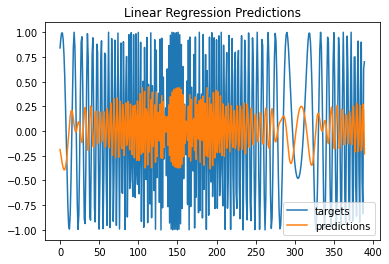

In [11]:
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

In [12]:
# still one step forecast using true targets (using previous code)
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1))[0, 0]
    i += 1
    # update predictions list
    validation_predictions.append(p)
    

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


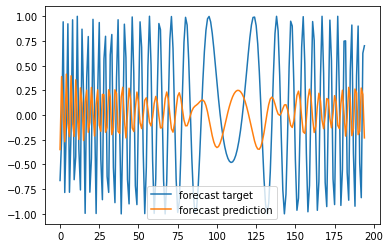

In [13]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [14]:
# multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2]    # 1D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1))[0,0]
    # update predictions list
    validation_predictions.append(p)
    # make new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


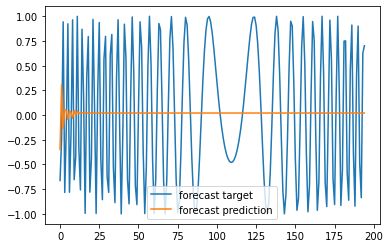

In [15]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Try RNN/LSTM model

In [16]:
X = X.reshape(-1, T, 1)     # N x T x D

In [17]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(units=10)(i)        # GRU, SimpleRNN
x = Dense(1)(x)

model = Model(i, x)

In [18]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.05))

In [19]:
# train the RNN
r = model.fit(X[:-N//2], Y[:-N//2],
              batch_size=32,
             epochs=200,
             validation_data=(X[-N//2:], Y[-N//2:]))

Epoch 1/200
7/7 [==============================] - 2s 78ms/step - loss: 0.5432 - val_loss: 0.5294
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 0.5068 - val_loss: 0.5434
Epoch 3/200
7/7 [==============================] - 0s 15ms/step - loss: 0.5152 - val_loss: 0.5535
Epoch 4/200
7/7 [==============================] - 0s 15ms/step - loss: 0.4816 - val_loss: 0.5340
Epoch 5/200
7/7 [==============================] - 0s 15ms/step - loss: 0.4384 - val_loss: 0.5248
Epoch 6/200
7/7 [==============================] - 0s 14ms/step - loss: 0.3205 - val_loss: 0.4684
Epoch 7/200
7/7 [==============================] - 0s 16ms/step - loss: 0.2636 - val_loss: 0.3434
Epoch 8/200
7/7 [==============================] - 0s 14ms/step - loss: 0.2095 - val_loss: 0.4069
Epoch 9/200
7/7 [==============================] - 0s 14ms/step - loss: 0.1875 - val_loss: 0.3024
Epoch 10/200
7/7 [==============================] - 0s 15ms/step - loss: 0.1503 - val_loss: 0.2921
Epoch 11/200
7/7 [=

Epoch 84/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.1353
Epoch 85/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.1453
Epoch 86/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.1320
Epoch 87/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.1446
Epoch 88/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.1362
Epoch 89/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.1442
Epoch 90/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.1441
Epoch 91/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.1361
Epoch 92/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.1451
Epoch 93/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.1414
Epoch 94/2

7/7 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 0.1300
Epoch 167/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.1365
Epoch 168/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.1318
Epoch 169/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.1371
Epoch 170/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.1299
Epoch 171/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.1490
Epoch 172/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.1353
Epoch 173/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 0.1373
Epoch 174/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.1340
Epoch 175/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.1294
Epoch 176/200


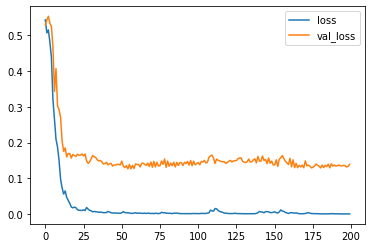

In [20]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

13/13 [==============================] - 0s 3ms/step
(390, 1)


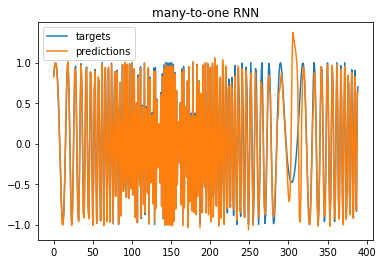

In [21]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

In [22]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
    # Reshape the input_ to N x T x D
    f = model.predict(input_.reshape(1, T, 1))[0,0]
    forecast.append(f)

    # make a new input with the latest forecast
    input_ = np.roll(input_, -1)
    input_[-1] = f



1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


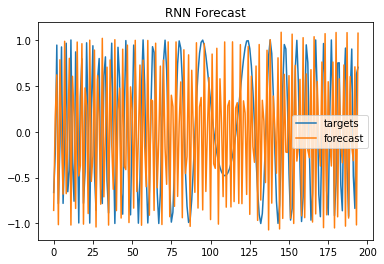

In [23]:
plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()